In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from common.src.main.python.utils.hdfs_generic import *
import os

MAX_N_EXECUTORS=15
MIN_N_EXECUTORS=1
N_CORES_EXECUTOR=4
EXECUTOR_IDLE_MAX_TIME=120
EXECUTOR_MEMORY='32g'
DRIVER_MEMORY='16g'
N_CORES_DRIVER=1
MEMORY_OVERHEAD=N_CORES_EXECUTOR*2048
#QUEUE="root.datascience.normal"
QUEUE="root.BDPtenants.es.medium"

BDA_CORE_VERSION="1.0.0"

SPARK_COMMON_OPTS=os.environ.get('SPARK_COMMON_OPTS', '')
SPARK_COMMON_OPTS+=" --executor-memory %s --driver-memory %s" % (EXECUTOR_MEMORY, DRIVER_MEMORY)
SPARK_COMMON_OPTS+=" --conf spark.shuffle.manager=tungsten-sort"
SPARK_COMMON_OPTS+="  --queue %s" % QUEUE
APP_NAME='AgeSegmentation'

# Dynamic allocation configuration
SPARK_COMMON_OPTS+=" --conf spark.driver.allowMultipleContexts=true"
SPARK_COMMON_OPTS+=" --conf spark.dynamicAllocation.enabled=true"
SPARK_COMMON_OPTS+=" --conf spark.shuffle.service.enabled=true"
SPARK_COMMON_OPTS+=" --conf spark.dynamicAllocation.maxExecutors=%s" % (MAX_N_EXECUTORS)
SPARK_COMMON_OPTS+=" --conf spark.dynamicAllocation.minExecutors=%s" % (MIN_N_EXECUTORS)
SPARK_COMMON_OPTS+=" --conf spark.dynamicAllocation.executorIdleTimeout=%s" % (EXECUTOR_IDLE_MAX_TIME)
SPARK_COMMON_OPTS+=" --conf spark.ui.port=58201"
SPARK_COMMON_OPTS+=" --conf spark.port.maxRetries=200"
SPARK_COMMON_OPTS+=" --executor-cores=%s" % (N_CORES_EXECUTOR)
SPARK_COMMON_OPTS+=" --conf spark.app.name=%s" % (APP_NAME)

BDA_ENV = os.environ.get('BDA_USER_HOME', '')

# Attach bda-core-ra codebase
SPARK_COMMON_OPTS+=" --files \
{}/scripts/properties/red_agent/nodes.properties,\
{}/scripts/properties/red_agent/nodes-de.properties,\
{}/scripts/properties/red_agent/nodes-es.properties,\
{}/scripts/properties/red_agent/nodes-ie.properties,\
{}/scripts/properties/red_agent/nodes-it.properties,\
{}/scripts/properties/red_agent/nodes-pt.properties,\
{}/scripts/properties/red_agent/nodes-uk.properties".format(*[BDA_ENV]*7)

os.environ["SPARK_COMMON_OPTS"] = SPARK_COMMON_OPTS
os.environ["PYSPARK_SUBMIT_ARGS"] = "%s pyspark-shell " % SPARK_COMMON_OPTS

#print os.environ.get('SPARK_COMMON_OPTS', '')
#print os.environ.get('PYSPARK_SUBMIT_ARGS', '')

sc, sparkSession, sqlContext = run_sc()
print sc.defaultParallelism

2


In [3]:
## import datetime, time
from pyspark.sql.functions import (col, lit, countDistinct,count, months_between, to_date, max as f_max
                                  ,when, desc, datediff, coalesce, concat, round as sql_round)
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
import datetime

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from pyspark.ml.feature import StandardScaler

In [4]:
spark = (SparkSession.builder
         .appName("AMDOCS Mobile Base Age Regressor")
         .master("yarn")
         .config("spark.submit.deployMode", "client")
         .config("spark.ui.showConsoleProgress", "true")
         .enableHiveSupport()
         .getOrCreate()
         )

# Age regression

We will try to infer customer age for each mobile service. Note that sometimes the user is not the owner of the contract (families, etc). 
Our ground truth is monoline customers with age informed. In this way, we need to avoid customer aggregated variables as our 

# Variables and paths

In [5]:
ClosingDay = '20200430'

ClosingDay_date = datetime.date(int(ClosingDay[:4]), int(ClosingDay[4:6]), int(ClosingDay[6:8]))


hdfs_partition_path = 'year=' + str(int(ClosingDay[:4])) + '/month=' + str(int(ClosingDay[4:6])) + '/day=' + str(int(ClosingDay[6:8]))
hdfs_write_path_common='/data/udf/vf_es/amdocs_ids/'
path_customer = hdfs_write_path_common +'customer/'+hdfs_partition_path
path_service = hdfs_write_path_common +'service/'+hdfs_partition_path
path_customer_agg = hdfs_write_path_common +'customer_agg/'+hdfs_partition_path
path_voiceusage = hdfs_write_path_common +'usage_geneva_voice/'+hdfs_partition_path
path_datausage = hdfs_write_path_common +'usage_geneva_data/'+hdfs_partition_path
path_billing = hdfs_write_path_common +'billing/'+hdfs_partition_path
path_campaignscustomer = hdfs_write_path_common +'campaigns_customer/'+hdfs_partition_path
path_campaignsservice = hdfs_write_path_common +'campaigns_service/'+hdfs_partition_path
#path_roamvoice = hdfs_write_path_common +'usage_geneva_roam_voice/'+hdfs_partition_path !!JOIN WITH IMSI
path_roamdata = hdfs_write_path_common +'usage_geneva_roam_data/'+hdfs_partition_path
path_orders_hist = hdfs_write_path_common +'orders/'+hdfs_partition_path
path_orders_agg = hdfs_write_path_common +'orders_agg/'+hdfs_partition_path
path_penal_cust = hdfs_write_path_common +'penalties_customer/'+hdfs_partition_path
path_penal_srv = hdfs_write_path_common +'penalties_service/'+hdfs_partition_path
path_devices = hdfs_write_path_common +'device_catalogue/'+hdfs_partition_path
path_ccc = hdfs_write_path_common +'call_centre_calls/'+hdfs_partition_path
path_tnps = hdfs_write_path_common +'tnps/'+hdfs_partition_path
path_perms_and_prefs = hdfs_write_path_common +'perms_and_prefs/'+hdfs_partition_path
#NEW!! Netscout apps
path_netscout_apps = hdfs_write_path_common +'netscout_apps/'+hdfs_partition_path
path_finaltable = hdfs_write_path_common + 'amdocs_ids_service_level/' + hdfs_partition_path
path_tmp_netscout='/data/udf/vf_es/amdocs_ids/tmp_netscout/tmp_apps/year=2018/month=11'

# Raw dataframe building

In [6]:
customerDF_load = (spark.read.load(path_customer))
serviceDF_load = (spark.read.load(path_service))
voiceUsageDF_load = (spark.read.load(path_voiceusage))
dataUsageDF_load = (spark.read.load(path_datausage))
penalties_serv_level_df_load = (spark.read.load(path_penal_srv))
devices_srv_df_load = (spark.read.load(path_devices))
netscout_apps_load = (spark.read.load(path_netscout_apps))
custAggServices=(spark.read.load(path_customer_agg))

In [7]:
data_CAR_SRV=(customerDF_load
      .join(custAggServices, 'NUM_CLIENTE', 'inner')
      .join(serviceDF_load, 'NUM_CLIENTE', 'inner')
      .join(voiceUsageDF_load, (col('msisdn') == col('id_msisdn')), 'leftouter')
      .join(dataUsageDF_load,(col('msisdn')==col('id_msisdn_data')), 'leftouter')
      .join(penalties_serv_level_df_load, ['NUM_CLIENTE','Instancia_P'], 'leftouter')
      .join(devices_srv_df_load, 'msisdn','leftouter')
      .join(netscout_apps_load, 'msisdn', 'leftouter')
      .withColumn('ClosingDay',lit(ClosingDay))
      )

# Target identification
We need to identify monoline customers with age informed

In [93]:
from pyspark.sql.functions import array_contains

#testing age as integer
data_train_test_pre0=(data_CAR_SRV
                  .where(col('rgu').isin(['mobile', 'prepaid']))
                  .filter(col('mobile_services_nc') == 1)
                  .groupBy(['NUM_CLIENTE', 'age'])
                  .agg(countDistinct('msisdn').alias('services'))
                  .withColumn('age_ok',when(col('age').between(10,100),1)
                                      .otherwise(0))
                  .withColumn('age_over_30',when(col('age_ok')==0, None)
                                            .when(col('age') > 30, 1).otherwise(0)
                             )
             )

In [94]:
data_train_test_pre1 = data_train_test_pre0.select(['NUM_CLIENTE','age_ok', 'age_over_30'])

As observed we have 1.269.103 labeled services which represents a very good start

In [95]:
data_train_test_pre2=(data_CAR_SRV   
                      .join(data_train_test_pre1, 'NUM_CLIENTE','leftouter')).cache()

In [96]:
data_train_test_tmp0=(data_train_test_pre2
                                                            
                .withColumn('ident_netscout',when(col('NS_APPS_ADULT_data_mb').isNull(),0)
                                              .otherwise(1))
                                            
                .withColumn('ident_gnv_voice',when(col('GNV_hour_0_W_MOU').isNull(),0)
                                              .otherwise(1))
                      
                .withColumn('ident_gnv_data',when(col('GNV_hour_0_WE_Chat_Zero_Data_Volume_MB').isNull(),0)
                                              .otherwise(1))
                .filter( (col('rgu')=='mobile'))
                .filter((col('ident_netscout')==1))
                .filter( (col('ident_gnv_data')==1))
                .filter((col('ident_gnv_voice')==1))     
                    ).cache()

In [16]:
data_train_test_tmp0.groupBy('age_over_30').count().show()

+-----------+-------+
|age_over_30|  count|
+-----------+-------+
|       null|3158180|
|          1|1007740|
|          0| 116047|
+-----------+-------+



# Feature eng.

In [97]:
feats_gnv_data= [c for c in data_train_test_tmp0.columns if (('GNV_hour' in c)&(~(('MOU') in c))&(~(('Num_Of_Calls') in c)))]
feats_gnv_voice= [c for c in data_train_test_tmp0.columns if (('GNV_hour' in c)& ((('MOU') in c)|(('Num_Of_Calls') in c)))]
feats_gnv_roam_data=[c for c in data_train_test_tmp0.columns if ( 'GNV_Roam' in c )]
feats_srv_price=[c for c in data_train_test_tmp0.columns if ( 'PRICE_' in c )]
feats_netscout=[c for c in data_train_test_tmp0.columns if (( 'NS_APPS' in c)& ((('effective') in c)|(('days') in c)) )]
feat_total_cuote=['MOBILE_BAM_TOTAL_CHARGES']
feats_date=['FX_SRV_BASIC', 'FX_TARIFF', 'FX_VOICE_TARIFF', 'FX_DATA', 'FX_DTO_LEV1', 'FX_DTO_LEV2', 'FX_DTO_LEV3', 'FX_DATA_ADDITIONAL', 'FX_OOB', 'FX_NETFLIX_NAPSTER', 'FX_ROAMING_BASIC', 'FX_ROAM_USA_EUR', 'FX_ROAM_ZONA_2', 'FX_CONSUM_MIN']
feats_categorical=['TARIFF', 'DTO_LEV1', 'DTO_LEV2', 'DTO_LEV3', 'DATA_ADDITIONAL', 'OOB', 'NETFLIX_NAPSTER', 'ROAMING_BASIC', 'ROAM_USA_EUR','ROAM_ZONA_2']
feats_basic=['NUM_CLIENTE', 'msisdn']#,'msisdn', 'CAMPO1', 'CAMPO2', 'CAMPO3']


# FEATS TO SUM
feats_gnv_voice_mou= [c for c in data_train_test_tmp0.columns if (('GNV_hour' in c)& (('MOU') in c))]
feats_gnv_voice_NOC= [c for c in data_train_test_tmp0.columns if (('GNV_hour' in c)& (('Num_Of_Calls') in c))]

feats_gnv_total_data_mb= [c for c in data_train_test_tmp0.columns if (('GNV_hour' in c)& (('Data_Volume_MB') in c))]
feats_gnv_data_mb_chatzero= [c for c in data_train_test_tmp0.columns if (('GNV_hour' in c)& (('Chat_Zero_Data_Volume_MB') in c))]
feats_gnv_data_mb_maps= [c for c in data_train_test_tmp0.columns if (('GNV_hour' in c)& (('Maps_Pass_Data_Volume_MB') in c))]
feats_gnv_data_mb_masmegas= [c for c in data_train_test_tmp0.columns if (('GNV_hour' in c)& (('MasMegas_Data_Volume_MB') in c))]
feats_gnv_data_mb_music= [c for c in data_train_test_tmp0.columns if (('GNV_hour' in c)& (('Music_Pass_Data_Volume_MB') in c))]
feats_gnv_data_mb_regular= [c for c in data_train_test_tmp0.columns if (('GNV_hour' in c)& (('RegularData_Data_Volume_MB') in c))]
feats_gnv_data_mb_social= [c for c in data_train_test_tmp0.columns if (('GNV_hour' in c)& (('Social_Pass_Data_Volume_MB') in c))]
feats_gnv_data_mb_videoHD= [c for c in data_train_test_tmp0.columns if (('GNV_hour' in c)& (('VideoHD_Pass_Data_Volume_MB') in c))]
feats_gnv_data_mb_video= [c for c in data_train_test_tmp0.columns if (('GNV_hour' in c)& (('Video_Pass_Data_Volume_MB') in c))]

In [98]:
data_train_test_tmp1=(data_train_test_tmp0
            .withColumn('Total_MOU', sum(coalesce(data_train_test_tmp0[cc], lit(0)) for cc in feats_gnv_voice_mou))
            .withColumn('Total_calls', sum(coalesce(data_train_test_tmp0[cc], lit(0)) for cc in feats_gnv_voice_NOC))
            .withColumn('Total_data_chatzero', sum(coalesce(data_train_test_tmp0[cc], lit(0)) for cc in feats_gnv_data_mb_chatzero))
            .withColumn('Total_data_maps', sum(coalesce(data_train_test_tmp0[cc], lit(0)) for cc in feats_gnv_data_mb_maps))
            .withColumn('Total_data_masmegas', sum(coalesce(data_train_test_tmp0[cc], lit(0)) for cc in feats_gnv_data_mb_masmegas))
            .withColumn('Total_data_music', sum(coalesce(data_train_test_tmp0[cc], lit(0)) for cc in feats_gnv_data_mb_music))
            .withColumn('Total_data_regular', sum(coalesce(data_train_test_tmp0[cc], lit(0)) for cc in feats_gnv_data_mb_regular))
            .withColumn('Total_data_social', sum(coalesce(data_train_test_tmp0[cc], lit(0)) for cc in feats_gnv_data_mb_social))
            .withColumn('Total_data_videoHD', sum(coalesce(data_train_test_tmp0[cc], lit(0)) for cc in feats_gnv_data_mb_videoHD))
            .withColumn('Total_data_video', sum(coalesce(data_train_test_tmp0[cc], lit(0)) for cc in feats_gnv_data_mb_video))
                      )

feats_total=[c for c in data_train_test_tmp1.columns if ( 'Total' in c )]

feats_fillna0 = feats_total + feats_gnv_data_mb_regular + feats_gnv_voice_mou  + feats_netscout 

In [99]:
data_train_test_tmp1=data_train_test_tmp1[feats_basic+feats_fillna0+feats_date+feats_categorical+['age_over_30']]

##### Null imputation
- Numerical values-->0
- Categorical values -->'NONE'

In [100]:
data_train_test_tmp2=data_train_test_tmp1.fillna(0, subset=feats_fillna0)
data_train_test_tmp3=data_train_test_tmp2.fillna('NO IDENT', subset=feats_categorical)

In [101]:
categoricalColumns = [item[0] for item in data_train_test_tmp3.dtypes if item[1].startswith('string')]
timestampColumns = [item[0] for item in data_train_test_tmp3.dtypes if item[1].startswith('timestamp')]

In [102]:
categoricalColumns.remove('msisdn')

In [103]:
data_train_test_tmp3 = data_train_test_tmp3.drop(*categoricalColumns)

In [104]:
declarados_o30 = data_train_test_tmp3.filter(col('age_over_30').isNotNull()).select('msisdn', 'age_over_30')

In [25]:
declarados_o30.groupBy('age_over_30').count().show()

+-----------+-------+
|age_over_30|  count|
+-----------+-------+
|          1|1007740|
|          0| 116047|
+-----------+-------+



# 1. Clientes de más de 30:

## Usaremos GMT (General Model Trainer) para el modelo de edad.

In [26]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append('/var/SP/data/home/avazq108/New_general_model_trainer')

from new_general_model_trainer import GeneralModelTrainer
from model_outputs import ModelParameters

modeler=GeneralModelTrainer(df=data_train_test_tmp3,label_col='age_over_30',ignore_cols=[])
modeler.relevelCategoricalVars() #se crea un diccionario que se puede cargar en ejecuciones posteriores


#data_train_test_tmp2

label_col is age_over_30 of type int
[Mon May 18 12:33:23 2020] Label age_over_30 is numeric, so no need of converting or indexing it


There are 0 ignore columns
There are 485 columns in given DataFrame
There are 1 int columns
There are 347 double columns
There are 122 bigint columns
There are 1 string columns
There are 14 timestamp columns


There are 1 categorical columns
There are 469 numeric columns
[Mon May 18 12:33:25 2020] Counting number of distinct values in categorical variables ...


Processing msisdn: 100%|██████████| 1/1 [01:00<00:00, 60.60s/variable]


[Mon May 18 12:34:25 2020] Counting number of distinct values in categorical variables ... done
[Mon May 18 12:34:25 2020] Detected 0 constant columns: []
[Mon May 18 12:34:25 2020] Writing cols_to_relevel to disk cols_to_relevel-20200518123425.txt
[Mon May 18 12:34:25 2020] Releveling 1 categorical variables with more than 32 levels, and dropping constant columns: ['msisdn']
[Mon May 18 12:34:26 2020] Releveled  1 categorical variables with more than 32 levels, and dropped constant columns


<new_general_model_trainer.GeneralModelTrainer instance at 0x7f4618ec6830>

In [27]:
modeler.generateFeaturesVector()

[Mon May 18 12:34:26 2020] Counting NULLs in label age_over_30 ...
[Mon May 18 12:36:17 2020] Counting NULLs in label age_over_30 ... 3158180
[Mon May 18 12:36:17 2020] Using column 'pred' to separate NULLs ...
[Mon May 18 12:36:21 2020] Using column 'pred' to separate NULLs ... done
[Mon May 18 12:36:21 2020] Indexing categorical features ...


Processing msisdn_releveled: 100%|██████████| 1/1 [00:15<00:00, 15.15s/variable]

[Mon May 18 12:36:36 2020] Indexing categorical features ... done


[Mon May 18 12:36:36 2020] Assembling 470 features ...
[Mon May 18 12:36:40 2020] Assembling 470 features ... done


<new_general_model_trainer.GeneralModelTrainer instance at 0x7f4618ec6830>

In [28]:
modeler.minMaxScale()

[Mon May 18 12:36:40 2020] Applying minMaxScaler to range [0.000000, 1.000000] ...
[Mon May 18 12:37:14 2020] Applying minMaxScaler to range [0.000000, 1.000000] ... done


<new_general_model_trainer.GeneralModelTrainer instance at 0x7f4618ec6830>

In [29]:
modeler.split_train_test()

[Mon May 18 12:37:15 2020] Found column "pred". Removing prediction rows for training
[Mon May 18 12:37:16 2020] Splitting data set into train(70%)/test(30%) ...
[Mon May 18 12:37:17 2020] Splitting data set into train(70%)/test(30%) ... done


<new_general_model_trainer.GeneralModelTrainer instance at 0x7f4618ec6830>

In [30]:
# modeler.reset_stages()

In [31]:
# Vamos a probar con GBTs 

from pyspark.ml.classification import RandomForestClassifier

#rfc = RandomForestClassifier(numTrees=1500, maxDepth=20, labelCol=modeler.get_label_col())

#modeler.train(ml_alg=rfc)
modeler.train()

[Mon May 18 12:37:17 2020] Not found column "pred". Removing null rows for training
[Mon May 18 12:37:18 2020] Balancing train data ...
[Mon May 18 12:37:33 2020] Sampling DataFrame by column age_over_30_without_nulls with fractions: {0: 1.0, 1: 0.11518582084158283} ...
[Mon May 18 12:37:34 2020] Sampling DataFrame by column age_over_30_without_nulls with fractions: {0: 1.0, 1: 0.11518582084158283} ... done
[Mon May 18 12:37:34 2020] Caching train data ...
[Mon May 18 12:37:35 2020] Caching train data ... done
[Mon May 18 12:37:35 2020] Balancing test data ...
[Mon May 18 12:37:46 2020] Sampling DataFrame by column age_over_30_without_nulls with fractions: {0: 1.0, 1: 0.11508534095008621} ...
[Mon May 18 12:37:47 2020] Sampling DataFrame by column age_over_30_without_nulls with fractions: {0: 1.0, 1: 0.11508534095008621} ... done
[Mon May 18 12:37:47 2020] Caching test data ...
[Mon May 18 12:37:47 2020] Caching test data ... done
[Mon May 18 12:37:49 2020] Added new stage: RandomFores

<new_general_model_trainer.GeneralModelTrainer instance at 0x7f4618ec6830>

In [32]:
modeler.evaluate()

Model Performance Metrics using (balanced) train data
[Mon May 18 12:42:15 2020] Predicting data ...
[Mon May 18 12:42:17 2020] Using element -1 as positive class
[Mon May 18 12:42:18 2020] Predicting data ... done
[Mon May 18 12:42:18 2020] Converting evaluation_predictions to Pandas ...
[Mon May 18 12:43:14 2020] Converting evaluation_predictions to Pandas ... done
matthews_corrcoef: 0.5253504622018508
f2_score: 0.7652311922574722
jaccard_similarity_score: 0.762660647771282
precision_score: 0.7597255406481652
classification_report:
              precision    recall  f1-score   support

           0       0.77      0.76      0.76     81275
           1       0.76      0.77      0.76     80881

   micro avg       0.76      0.76      0.76    162156
   macro avg       0.76      0.76      0.76    162156
weighted avg       0.76      0.76      0.76    162156

average_precision_score: 0.8306138154772367
confusion_matrix:
[[61665, 19610], [18876, 62005]]
hinge_loss: 0.8762393401143892
f1_scor

<new_general_model_trainer.GeneralModelTrainer instance at 0x7f4618ec6830>

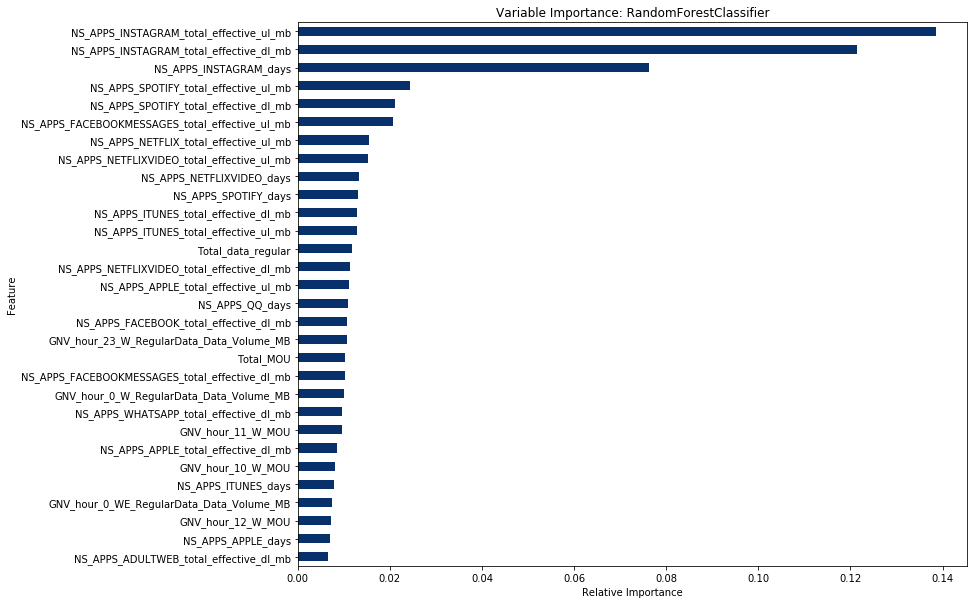

In [33]:
modeler.varimp_plot()

<Figure size 648x432 with 0 Axes>

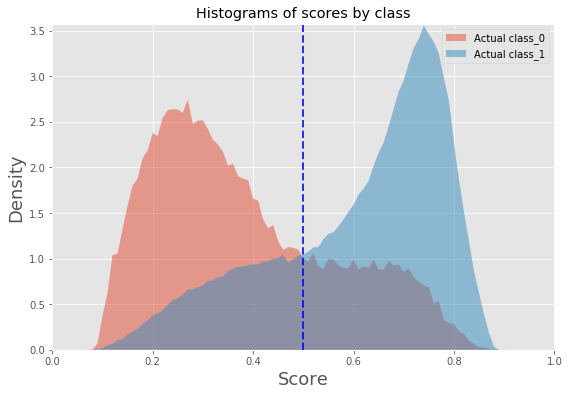

In [34]:
modeler.plot_scores_histograms(modeler.metrics_unbalanced_test, figsize=(9,6))

In [35]:
modeler.predict()

[Mon May 18 12:45:35 2020] Selecting rows to predict
[Mon May 18 12:45:35 2020] Found column "pred". Selecting prediction rows
[Mon May 18 12:45:35 2020] Predicting data ...
[Mon May 18 12:45:38 2020] Using last element as positive class
[Mon May 18 12:45:39 2020] Predicting data ... done


<new_general_model_trainer.GeneralModelTrainer instance at 0x7f4618ec6830>

In [36]:
modeler.predictions.groupBy('prediction').count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|1295949|
|       1.0|2986018|
+----------+-------+



In [37]:
predicciones = modeler.predictions.select('msisdn', 'prediction')

In [41]:
df_over_30 = predicciones.withColumnRenamed('prediction', 'age_over_30')

# 2. Clientes menores de 25.

In [105]:
#testing age as integer
data_train_test_pre0=(data_CAR_SRV
                  .where(col('rgu').isin(['mobile', 'prepaid']))
                  .filter(col('mobile_services_nc') == 1)
                  .groupBy(['NUM_CLIENTE', 'age'])
                  .agg(countDistinct('msisdn').alias('services'))
                  .withColumn('age_ok',when(col('age').between(10,100),1)
                                      .otherwise(0))
                  .withColumn('age_under_25',when(col('age_ok')==0, None)
                                            .when(col('age') < 25, 1).otherwise(0)
                             )
             )

In [106]:
data_train_test_pre1 = data_train_test_pre0.select(['NUM_CLIENTE','age_ok', 'age_under_25'])

In [107]:
data_train_test_pre2=(data_CAR_SRV   
                      .join(data_train_test_pre1, 'NUM_CLIENTE','leftouter')).cache()

In [108]:
data_train_test_tmp0=(data_train_test_pre2
                                                            
                .withColumn('ident_netscout',when(col('NS_APPS_ADULT_data_mb').isNull(),0)
                                              .otherwise(1))
                                            
                .withColumn('ident_gnv_voice',when(col('GNV_hour_0_W_MOU').isNull(),0)
                                              .otherwise(1))
                      
                .withColumn('ident_gnv_data',when(col('GNV_hour_0_WE_Chat_Zero_Data_Volume_MB').isNull(),0)
                                              .otherwise(1))
                .filter( (col('rgu')=='mobile'))
                .filter((col('ident_netscout')==1))
                .filter( (col('ident_gnv_data')==1))
                .filter((col('ident_gnv_voice')==1))     
                    ).cache()

In [52]:
data_train_test_tmp0.groupBy('age_under_25').count().show()

+------------+-------+
|age_under_25|  count|
+------------+-------+
|        null|3158180|
|           1|  26270|
|           0|1097517|
+------------+-------+



In [109]:
feats_gnv_data= [c for c in data_train_test_tmp0.columns if (('GNV_hour' in c)&(~(('MOU') in c))&(~(('Num_Of_Calls') in c)))]
feats_gnv_voice= [c for c in data_train_test_tmp0.columns if (('GNV_hour' in c)& ((('MOU') in c)|(('Num_Of_Calls') in c)))]
feats_gnv_roam_data=[c for c in data_train_test_tmp0.columns if ( 'GNV_Roam' in c )]
feats_srv_price=[c for c in data_train_test_tmp0.columns if ( 'PRICE_' in c )]
feats_netscout=[c for c in data_train_test_tmp0.columns if (( 'NS_APPS' in c)& ((('effective') in c)|(('days') in c)) )]
feat_total_cuote=['MOBILE_BAM_TOTAL_CHARGES']
feats_date=['FX_SRV_BASIC', 'FX_TARIFF', 'FX_VOICE_TARIFF', 'FX_DATA', 'FX_DTO_LEV1', 'FX_DTO_LEV2', 'FX_DTO_LEV3', 'FX_DATA_ADDITIONAL', 'FX_OOB', 'FX_NETFLIX_NAPSTER', 'FX_ROAMING_BASIC', 'FX_ROAM_USA_EUR', 'FX_ROAM_ZONA_2', 'FX_CONSUM_MIN']
feats_categorical=['TARIFF', 'DTO_LEV1', 'DTO_LEV2', 'DTO_LEV3', 'DATA_ADDITIONAL', 'OOB', 'NETFLIX_NAPSTER', 'ROAMING_BASIC', 'ROAM_USA_EUR','ROAM_ZONA_2']
feats_basic=['NUM_CLIENTE', 'msisdn']#,'msisdn', 'CAMPO1', 'CAMPO2', 'CAMPO3']


# FEATS TO SUM
feats_gnv_voice_mou= [c for c in data_train_test_tmp0.columns if (('GNV_hour' in c)& (('MOU') in c))]
feats_gnv_voice_NOC= [c for c in data_train_test_tmp0.columns if (('GNV_hour' in c)& (('Num_Of_Calls') in c))]

feats_gnv_total_data_mb= [c for c in data_train_test_tmp0.columns if (('GNV_hour' in c)& (('Data_Volume_MB') in c))]
feats_gnv_data_mb_chatzero= [c for c in data_train_test_tmp0.columns if (('GNV_hour' in c)& (('Chat_Zero_Data_Volume_MB') in c))]
feats_gnv_data_mb_maps= [c for c in data_train_test_tmp0.columns if (('GNV_hour' in c)& (('Maps_Pass_Data_Volume_MB') in c))]
feats_gnv_data_mb_masmegas= [c for c in data_train_test_tmp0.columns if (('GNV_hour' in c)& (('MasMegas_Data_Volume_MB') in c))]
feats_gnv_data_mb_music= [c for c in data_train_test_tmp0.columns if (('GNV_hour' in c)& (('Music_Pass_Data_Volume_MB') in c))]
feats_gnv_data_mb_regular= [c for c in data_train_test_tmp0.columns if (('GNV_hour' in c)& (('RegularData_Data_Volume_MB') in c))]
feats_gnv_data_mb_social= [c for c in data_train_test_tmp0.columns if (('GNV_hour' in c)& (('Social_Pass_Data_Volume_MB') in c))]
feats_gnv_data_mb_videoHD= [c for c in data_train_test_tmp0.columns if (('GNV_hour' in c)& (('VideoHD_Pass_Data_Volume_MB') in c))]
feats_gnv_data_mb_video= [c for c in data_train_test_tmp0.columns if (('GNV_hour' in c)& (('Video_Pass_Data_Volume_MB') in c))]

In [110]:
data_train_test_tmp1=(data_train_test_tmp0
            .withColumn('Total_MOU', sum(coalesce(data_train_test_tmp0[cc], lit(0)) for cc in feats_gnv_voice_mou))
            .withColumn('Total_calls', sum(coalesce(data_train_test_tmp0[cc], lit(0)) for cc in feats_gnv_voice_NOC))
            .withColumn('Total_data_chatzero', sum(coalesce(data_train_test_tmp0[cc], lit(0)) for cc in feats_gnv_data_mb_chatzero))
            .withColumn('Total_data_maps', sum(coalesce(data_train_test_tmp0[cc], lit(0)) for cc in feats_gnv_data_mb_maps))
            .withColumn('Total_data_masmegas', sum(coalesce(data_train_test_tmp0[cc], lit(0)) for cc in feats_gnv_data_mb_masmegas))
            .withColumn('Total_data_music', sum(coalesce(data_train_test_tmp0[cc], lit(0)) for cc in feats_gnv_data_mb_music))
            .withColumn('Total_data_regular', sum(coalesce(data_train_test_tmp0[cc], lit(0)) for cc in feats_gnv_data_mb_regular))
            .withColumn('Total_data_social', sum(coalesce(data_train_test_tmp0[cc], lit(0)) for cc in feats_gnv_data_mb_social))
            .withColumn('Total_data_videoHD', sum(coalesce(data_train_test_tmp0[cc], lit(0)) for cc in feats_gnv_data_mb_videoHD))
            .withColumn('Total_data_video', sum(coalesce(data_train_test_tmp0[cc], lit(0)) for cc in feats_gnv_data_mb_video))
                      )

feats_total=[c for c in data_train_test_tmp1.columns if ( 'Total' in c )]

feats_fillna0 = feats_total + feats_gnv_data_mb_regular + feats_gnv_voice_mou  + feats_netscout 

In [111]:
data_train_test_tmp1=data_train_test_tmp1[feats_basic+feats_fillna0+feats_date+feats_categorical+['age_under_25']]

In [112]:
data_train_test_tmp2=data_train_test_tmp1.fillna(0, subset=feats_fillna0)
data_train_test_tmp3=data_train_test_tmp2.fillna('NO IDENT', subset=feats_categorical)

In [113]:
categoricalColumns = [item[0] for item in data_train_test_tmp3.dtypes if item[1].startswith('string')]
timestampColumns = [item[0] for item in data_train_test_tmp3.dtypes if item[1].startswith('timestamp')]

In [114]:
categoricalColumns.remove('msisdn')

In [115]:
data_train_test_tmp3 = data_train_test_tmp3.drop(*categoricalColumns)

In [116]:
declarados_u25 = data_train_test_tmp3.filter(col('age_under_25').isNotNull()).select('msisdn', 'age_under_25')

In [61]:
declarados_u25.groupBy('age_under_25').count().show()

+------------+-------+
|age_under_25|  count|
+------------+-------+
|           1|  26270|
|           0|1097517|
+------------+-------+



## Utilizamos, nuevamente, GMT para entrenar el modelo.

In [62]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append('/var/SP/data/home/avazq108/New_general_model_trainer')

from new_general_model_trainer import GeneralModelTrainer
from model_outputs import ModelParameters

modeler=GeneralModelTrainer(df=data_train_test_tmp3,label_col='age_under_25',ignore_cols=[])
modeler.relevelCategoricalVars() #se crea un diccionario que se puede cargar en ejecuciones posteriores

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
label_col is age_under_25 of type int
[Mon May 18 13:34:19 2020] Label age_under_25 is numeric, so no need of converting or indexing it


There are 0 ignore columns
There are 485 columns in given DataFrame
There are 1 int columns
There are 347 double columns
There are 122 bigint columns
There are 1 string columns
There are 14 timestamp columns


There are 1 categorical columns
There are 469 numeric columns
[Mon May 18 13:34:21 2020] Counting number of distinct values in categorical variables ...


Processing msisdn: 100%|██████████| 1/1 [01:26<00:00, 86.08s/variable]


[Mon May 18 13:35:47 2020] Counting number of distinct values in categorical variables ... done
[Mon May 18 13:35:47 2020] Detected 0 constant columns: []
[Mon May 18 13:35:47 2020] Writing cols_to_relevel to disk cols_to_relevel-20200518133547.txt
[Mon May 18 13:35:47 2020] Releveling 1 categorical variables with more than 32 levels, and dropping constant columns: ['msisdn']
[Mon May 18 13:35:48 2020] Releveled  1 categorical variables with more than 32 levels, and dropped constant columns


<new_general_model_trainer.GeneralModelTrainer instance at 0x7f45ead33a70>

In [63]:
modeler.generateFeaturesVector()

[Mon May 18 13:35:48 2020] Counting NULLs in label age_under_25 ...
[Mon May 18 13:35:51 2020] Counting NULLs in label age_under_25 ... 3158180
[Mon May 18 13:35:51 2020] Using column 'pred' to separate NULLs ...
[Mon May 18 13:35:55 2020] Using column 'pred' to separate NULLs ... done
[Mon May 18 13:35:55 2020] Indexing categorical features ...


Processing msisdn_releveled: 100%|██████████| 1/1 [00:04<00:00,  4.70s/variable]

[Mon May 18 13:35:59 2020] Indexing categorical features ... done


[Mon May 18 13:35:59 2020] Assembling 470 features ...
[Mon May 18 13:36:02 2020] Assembling 470 features ... done


<new_general_model_trainer.GeneralModelTrainer instance at 0x7f45ead33a70>

In [64]:
modeler.minMaxScale()

[Mon May 18 13:36:02 2020] Applying minMaxScaler to range [0.000000, 1.000000] ...
[Mon May 18 13:36:26 2020] Applying minMaxScaler to range [0.000000, 1.000000] ... done


<new_general_model_trainer.GeneralModelTrainer instance at 0x7f45ead33a70>

In [65]:
modeler.split_train_test()

[Mon May 18 13:36:27 2020] Found column "pred". Removing prediction rows for training
[Mon May 18 13:36:28 2020] Splitting data set into train(70%)/test(30%) ...
[Mon May 18 13:36:29 2020] Splitting data set into train(70%)/test(30%) ... done


<new_general_model_trainer.GeneralModelTrainer instance at 0x7f45ead33a70>

In [66]:
from pyspark.ml.classification import RandomForestClassifier

modeler.train()

[Mon May 18 13:36:29 2020] Not found column "pred". Removing null rows for training
[Mon May 18 13:36:30 2020] Balancing train data ...
[Mon May 18 13:36:42 2020] Sampling DataFrame by column age_under_25_without_nulls with fractions: {0: 0.024004851462986775, 1: 1.0} ...
[Mon May 18 13:36:43 2020] Sampling DataFrame by column age_under_25_without_nulls with fractions: {0: 0.024004851462986775, 1: 1.0} ... done
[Mon May 18 13:36:43 2020] Caching train data ...
[Mon May 18 13:36:44 2020] Caching train data ... done
[Mon May 18 13:36:44 2020] Balancing test data ...
[Mon May 18 13:36:55 2020] Sampling DataFrame by column age_under_25_without_nulls with fractions: {0: 0.023774723555026148, 1: 1.0} ...
[Mon May 18 13:36:55 2020] Sampling DataFrame by column age_under_25_without_nulls with fractions: {0: 0.023774723555026148, 1: 1.0} ... done
[Mon May 18 13:36:55 2020] Caching test data ...
[Mon May 18 13:36:56 2020] Caching test data ... done
[Mon May 18 13:36:57 2020] Added new stage: Ran

<new_general_model_trainer.GeneralModelTrainer instance at 0x7f45ead33a70>

In [67]:
modeler.evaluate()

Model Performance Metrics using (balanced) train data
[Mon May 18 13:41:28 2020] Predicting data ...
[Mon May 18 13:41:30 2020] Using element -1 as positive class
[Mon May 18 13:41:31 2020] Predicting data ... done
[Mon May 18 13:41:31 2020] Converting evaluation_predictions to Pandas ...
[Mon May 18 13:41:59 2020] Converting evaluation_predictions to Pandas ... done
matthews_corrcoef: 0.6509486641389751
f2_score: 0.8176933472839828
jaccard_similarity_score: 0.8253422789505264
precision_score: 0.8350957257346393
classification_report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83     18220
           1       0.84      0.81      0.82     18446

   micro avg       0.83      0.83      0.83     36666
   macro avg       0.83      0.83      0.83     36666
weighted avg       0.83      0.83      0.83     36666

average_precision_score: 0.9097714231101997
confusion_matrix:
[[15257, 2963], [3441, 15005]]
hinge_loss: 0.8239454654534255
f1_score

<new_general_model_trainer.GeneralModelTrainer instance at 0x7f45ead33a70>

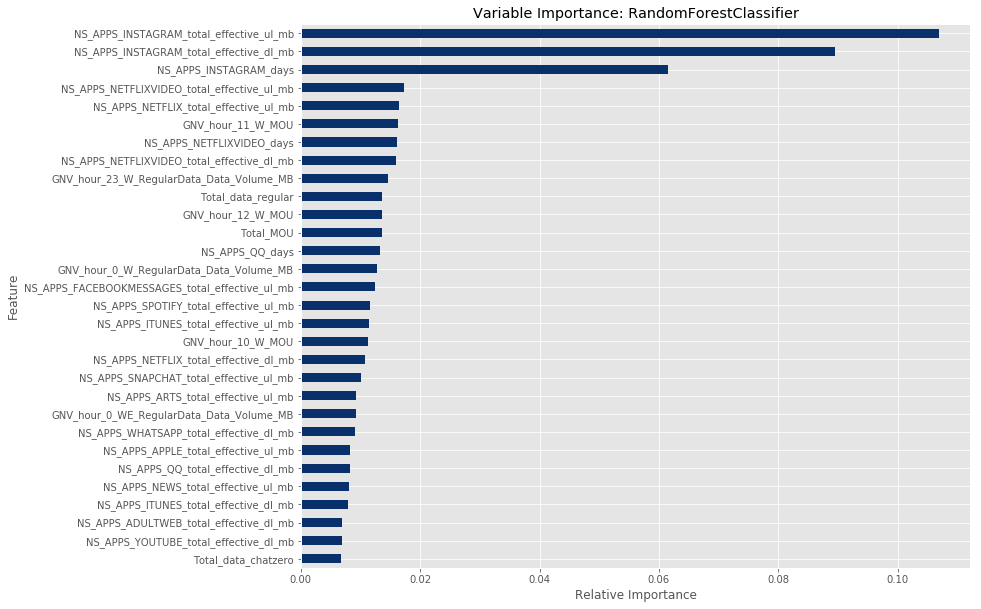

In [68]:
modeler.varimp_plot()

<Figure size 648x432 with 0 Axes>

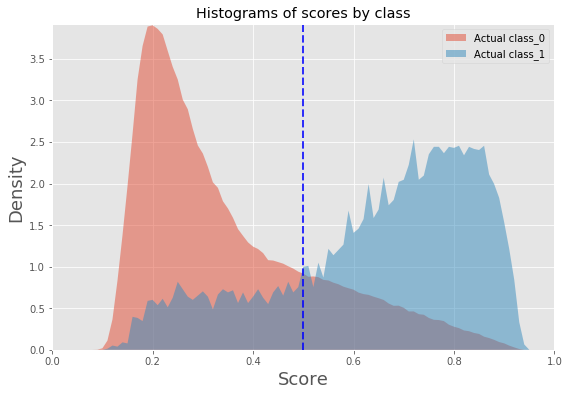

In [69]:
modeler.plot_scores_histograms(modeler.metrics_unbalanced_test, figsize=(9,6))

In [70]:
modeler.predict()

[Mon May 18 13:43:32 2020] Selecting rows to predict
[Mon May 18 13:43:32 2020] Found column "pred". Selecting prediction rows
[Mon May 18 13:43:33 2020] Predicting data ...
[Mon May 18 13:43:35 2020] Using last element as positive class
[Mon May 18 13:43:36 2020] Predicting data ... done


<new_general_model_trainer.GeneralModelTrainer instance at 0x7f45ead33a70>

In [71]:
modeler.predictions.groupBy('prediction').count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|3275295|
|       1.0|1006672|
+----------+-------+



In [72]:
predicciones = modeler.predictions.select('msisdn', 'prediction')

In [73]:
df_under_25 = predicciones.withColumnRenamed('prediction', 'age_under_25')

In [74]:
df_under_25.count()

4281967

In [75]:
df_over_30.count()

4281967

In [86]:
df_all = df_under_25.join(df_over_30, on = 'msisdn', how = 'inner')

In [77]:
df_all.count()

4281967

In [78]:
df_all.groupby('age_under_25', 'age_over_30').count().show()

+------------+-----------+-------+
|age_under_25|age_over_30|  count|
+------------+-----------+-------+
|         1.0|        1.0|   9039|
|         0.0|        1.0|2976979|
|         1.0|        0.0| 997633|
|         0.0|        0.0| 298316|
+------------+-----------+-------+



In [87]:
df_all = df_all.withColumn('edad_final', 
                  when(col('age_under_25') == 1, 0)
                  .when(col('age_over_30') == 1, 2)
                  .when((col('age_under_25') == 0) & (col('age_over_30') == 0), 1)
                  .when((col('age_under_25') == 1) & (col('age_over_30') == 1), -1)
                 )

In [88]:
df_all = df_all.filter(col('edad_final') != -1)

In [89]:
df_all.groupby('edad_final','age_under_25', 'age_over_30').count().show()

+----------+------------+-----------+-------+
|edad_final|age_under_25|age_over_30|  count|
+----------+------------+-----------+-------+
|         1|         0.0|        0.0| 298316|
|         0|         1.0|        0.0| 997633|
|         2|         0.0|        1.0|2976979|
|         0|         1.0|        1.0|   9039|
+----------+------------+-----------+-------+



In [90]:
df_all = df_all.withColumn('prediction', 
                           when(col('edad_final') == 0, "Under 25")
                           .when(col('edad_final') == 1, "Between 25 and 30")
                           .when(col('edad_final') == 2, "Older than 30")
                          )

In [91]:
df_all.groupby('prediction').count().show()

+-----------------+-------+
|       prediction|  count|
+-----------------+-------+
|         Under 25|1006672|
|Between 25 and 30| 298316|
|    Older than 30|2976979|
+-----------------+-------+



In [118]:
df_all.count()

4281967

## Preparamos salida para Model Outputs.

In [122]:
level = 'msisdn'

model_name = 'age_prediction'

current_timestamp = datetime.datetime.now()

path_model_detail = 'model_name=' + model_name \
                            + '/year=' + str(current_timestamp.year) \
                            + '/month=' + str(current_timestamp.month) \
                            + '/day=0'

path_model_outputs_base = '/data/attributes/vf_es/model_outputs/'
path_model_outputs_scores = path_model_outputs_base + 'model_scores/' + path_model_detail

In [123]:
executed_at = current_timestamp.strftime('%Y-%m-%d %H:%M:%S')
time = int(current_timestamp.strftime('%H%M%S'))

In [125]:
from pyspark.sql.types import DoubleType, StringType, IntegerType, ArrayType, FloatType

df_save_scores = (df_all
                        .withColumn('executed_at', lit(executed_at).cast(StringType()))
                        .withColumn('model_executed_at', lit(executed_at).cast(StringType()))
                        .withColumn('predict_closing_date', lit(ClosingDay).cast(StringType()))
                        .withColumn('msisdn', col('msisdn').cast(StringType()))
                        .withColumn('client_id', lit(None).cast(StringType()))
                        .withColumn('nif', lit(None).cast(StringType()))
                        .withColumn('model_output', col('edad_final').cast(StringType()))
                        .withColumn('scoring', lit(None).cast(FloatType()))
                        .withColumn('prediction', col('prediction').cast(StringType()))
                        .withColumn('extra_info', lit(None).cast(StringType()))
                        .withColumn('time', lit(time).cast(IntegerType()))
                        .withColumn('model_name', lit(model_name).cast(StringType()))
                        .select('executed_at', 'model_executed_at', 'predict_closing_date', 'msisdn'
                                       , 'client_id', 'nif', 'model_output', 'scoring', 'prediction'
                                       , 'extra_info', 'time')
                            )

In [127]:
df_pandas = df_save_scores.limit(20).toPandas()

In [131]:
df_pandas.to_csv('sample_age_prediction.csv', sep = ';', index = False)

In [128]:
df_pandas

,executed_at,model_executed_at,predict_closing_date,msisdn,client_id,nif,model_output,scoring,prediction,extra_info,time
0,2020-05-18 16:37:57,2020-05-18 16:37:57,20200430,600000070,None,None,2,NaN,Older than 30,None,163757
1,2020-05-18 16:37:57,2020-05-18 16:37:57,20200430,600005109,None,None,2,NaN,Older than 30,None,163757
2,2020-05-18 16:37:57,2020-05-18 16:37:57,20200430,600009508,None,None,2,NaN,Older than 30,None,163757
3,2020-05-18 16:37:57,2020-05-18 16:37:57,20200430,600012037,None,None,2,NaN,Older than 30,None,163757
4,2020-05-18 16:37:57,2020-05-18 16:37:57,20200430,600015412,None,None,2,NaN,Older than 30,None,163757
5,2020-05-18 16:37:57,2020-05-18 16:37:57,20200430,600021796,None,None,2,NaN,Older than 30,None,163757
6,2020-05-18 16:37:57,2020-05-18 16:37:57,20200430,600023343,None,None,2,NaN,Older than 30,None,163757
7,2020-05-18 16:37:57,2020-05-18 16:37:57,20200430,600033953,None,None,2,NaN,Older than 30,None,163757
8,2020-05-18 16:37:57,2020-05-18 16:37:57,20200430,600037345,None,None,2,NaN,Older than 30,None,163757
9,2020-05-18 16:37:57,2020-05-18 16:37:57,20200430,600041651,None,None,2,NaN,Older than 30,None,163757


In [129]:
def saveDF(path, df, partitions):
    print('Saving started in: %s', path)
    spark.conf.set("spark.sql.sources.partitionOverwriteMode","dynamic")
    df.repartition(partitions).write.mode('append').format('parquet').save(path)
    print('Saving finished!')

In [130]:
saveDF(path_model_outputs_scores, df_save_scores, 1)

('Saving started in: %s', '/data/attributes/vf_es/model_outputs/model_scores/model_name=age_prediction/year=2020/month=5/day=0')
Saving finished!


In [ ]:
spark.stop()